In [1]:
import yfinance as yf
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import mean_squared_error


In [2]:
# Fetch stock data
data = yf.download("AAPL", start="2015-01-01", end="2023-01-01")
data = data[['Close']]  # We only need the closing price for prediction


[*********************100%***********************]  1 of 1 completed


In [3]:
# Scale data between 0 and 1
scaler = MinMaxScaler()
data['Close'] = scaler.fit_transform(data[['Close']])

# Prepare data for supervised learning
def create_sequences(data, seq_length=5):
    X = []
    y = []
    for i in range(len(data) - seq_length):
        X.append(data[i:i + seq_length])
        y.append(data[i + seq_length])
    return np.array(X), np.array(y)

# Create sequences of 5 days
seq_length = 5
X, y = create_sequences(data['Close'].values, seq_length=seq_length)


C:\Users\sanje\AppData\Local\Temp\ipykernel_23284\3301195606.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Close'] = scaler.fit_transform(data[['Close']])


In [4]:
# Split into training and testing data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Reshape X for MLP (flattening sequence data)
X_train = X_train.reshape(X_train.shape[0], -1)
X_test = X_test.reshape(X_test.shape[0], -1)


In [5]:
# Define the MLP model
model = Sequential()
model.add(Dense(64, input_dim=X_train.shape[1], activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dense(16, activation='relu'))
model.add(Dense(1))  # Output layer for regression

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001), loss='mse')


In [6]:
# Train the model
history = model.fit(X_train, y_train, epochs=100, batch_size=16, validation_data=(X_test, y_test), verbose=1)


Epoch 1/100
101/101 [==============================] - 3s 10ms/step - loss: 0.0488 - val_loss: 3.5664e-04
Epoch 2/100
101/101 [==============================] - 1s 6ms/step - loss: 3.0361e-04 - val_loss: 2.9183e-04
Epoch 3/100
101/101 [==============================] - 1s 5ms/step - loss: 3.0394e-04 - val_loss: 3.9597e-04
Epoch 4/100
101/101 [==============================] - 0s 5ms/step - loss: 2.7388e-04 - val_loss: 2.1408e-04
Epoch 5/100
101/101 [==============================] - 1s 5ms/step - loss: 2.4643e-04 - val_loss: 2.2162e-04
Epoch 6/100
101/101 [==============================] - 0s 5ms/step - loss: 2.4575e-04 - val_loss: 1.9045e-04
Epoch 7/100
101/101 [==============================] - 1s 5ms/step - loss: 2.7781e-04 - val_loss: 2.4302e-04
Epoch 8/100
101/101 [==============================] - 0s 5ms/step - loss: 2.3460e-04 - val_loss: 1.7830e-04
Epoch 9/100
101/101 [==============================] - 0s 5ms/step - loss: 2.1986e-04 - val_loss: 2.1971e-04
Epoch 10/100
101/101 [

In [10]:
# Make predictions
y_pred = model.predict(X_test)
predicted_price = scaler.inverse_transform(y_pred)[0][0]
print(f"Predicted next day price: {predicted_price}")

# Reverse the scaling of data to get actual stock prices
y_test_inv = scaler.inverse_transform(y_test.reshape(-1, 1))
y_pred_inv = scaler.inverse_transform(y_pred)

# Calculate MSE
mse = mean_squared_error(y_test_inv, y_pred_inv)
print(f"Mean Squared Error: {mse}")


13/13 [==============================] - 0s 4ms/step
Predicted next day price: 129.26858520507812
Mean Squared Error: 4.483417923975444


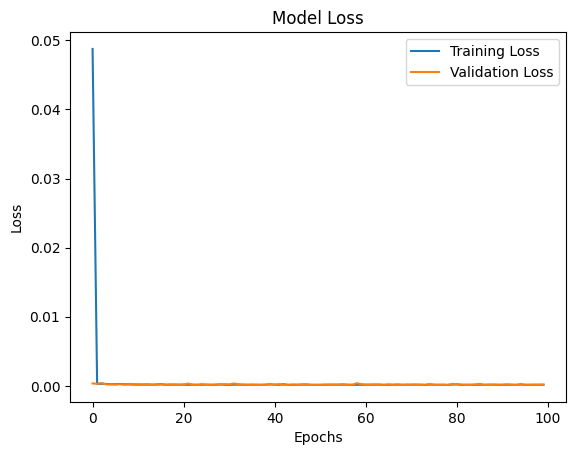

In [11]:
#Plot the training and validation loss over epochs to evaluate model performance.
import matplotlib.pyplot as plt

# Plot training & validation loss values
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


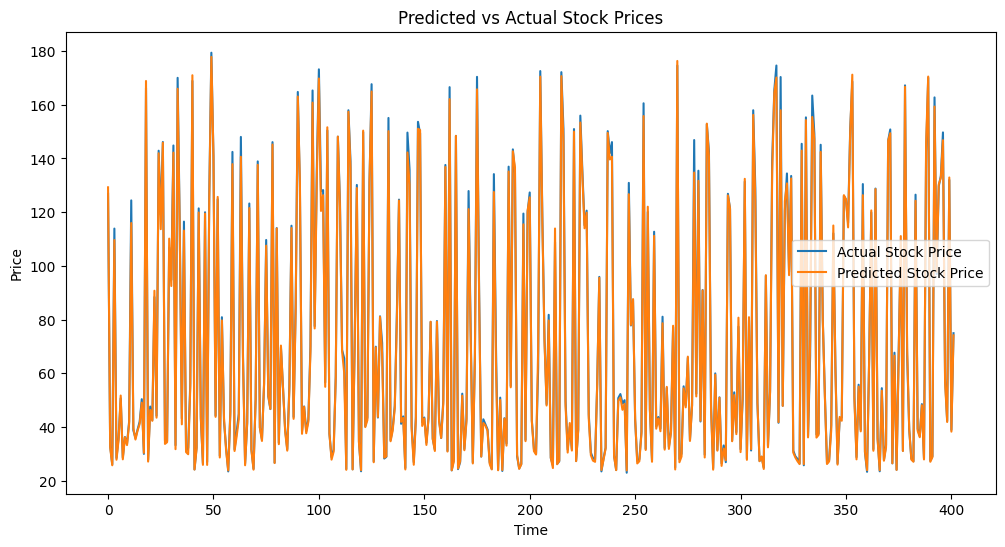

In [12]:
plt.figure(figsize=(12, 6))
plt.plot(y_test_inv, label='Actual Stock Price')
plt.plot(y_pred_inv, label='Predicted Stock Price')
plt.title('Predicted vs Actual Stock Prices')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.show()
